# Notebook to analyze Faculty in Geosciences Data

All data was taken from a spreadsheet created where we looked at 62 different Universities and their faculty makeup. We scrubbed names and split the data into two dataframes to improve anonymity of the data, and those two dataframes are available for use and reproduction of the work. Grad student data is from NSF data available at: 

# Import Dependencies and Set up Notebook with Drive

In [1]:
#import dependencies
import pandas as pd #for those new to python, pandas will be what we use to make our 'dataframes' and is the easiest way to manipulate this data
import matplotlib.pyplot as plt #matplotlib is how we plot
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import interp1d


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#when you run this cell, you will see a link pop up below. 
#Click on it and copy and paste the password it gives you into the box that appears below. 
#This authorizes the google drive to be used
#to check it works: you will have to click the 'files' option to the left, and the refresh files button--your drive will show up


Mounted at /content/drive


#Import Data

In [3]:
uni_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/university_data.csv', index_col = 0)
disc_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/discipline_data.csv',index_col = 0)
grad_pd_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/grad_postdoc_data.csv')
grad_time_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/grad_time_data.csv', index_col = 1).drop('Unnamed: 0', axis=1)

# Data Modification

# Figure 1: Multi-decadal time-series of gender distribution in faculty by rank

In [4]:
#calculate percent faculty
# add in other years of data (Wilson 1999, ...(fill out other citations))
other_data_dict = {'assistant professor':[22, 26, 27, 30, 32, 36],
                   'associate professor':[14, 15, 15, 18, 21, 24],
                   'professor':[5, 8, 8, 10, 11, 13]}
percent_faculty_df = uni_df.groupby(['Gender','Career Stage']).count().drop(columns = ['dept_head_gender','private_public'])
faculty_time_df = pd.DataFrame(index = ['assistant professor', 'associate professor', 'professor'], columns = [1999, 2002, 2008, 2010, 2013, 2015, 2020])
for lev in other_data_dict.keys():
  other_data_dict[lev].append((percent_faculty_df.loc['f']/(percent_faculty_df.loc['m']+percent_faculty_df.loc['f'])).loc[lev].values[0]*100)
  faculty_time_df.loc[lev] = other_data_dict[lev]
#faculty_time_df.loc['all'] = [12.5, 13, 17, 20, percent_faculty_df.loc['f'].sum()/(percent_faculty_df.sum())]
faculty_time_df = faculty_time_df.transpose()



In [5]:
#calculate percent grad students
grad_time_df['percent_female'] = grad_time_df['Female']/(grad_time_df['Female'] + grad_time_df['Male'])*100

In [6]:
# interpolate the percentages of women over the full range of years 1999-2021
f_assist = interp1d(faculty_time_df.index, faculty_time_df['assistant professor'])
f_assoc = interp1d(faculty_time_df.index, faculty_time_df['associate professor'])
f_prof = interp1d(faculty_time_df.index, faculty_time_df['professor'])
interp_dict = {'assistant professor':f_assist, 'associate professor':f_assoc,'professor':f_prof}
years = list(range(1999,2021))

faculty_interp_df = pd.DataFrame(index = years, columns = ['assistant professor interp', 'associate professor interp', 'professor interp'])
for lev in faculty_time_df.columns:
  faculty_interp_df[lev + ' interp'] = interp_dict[lev](years)

faculty_interp_df.index = faculty_interp_df.index.rename('Year')

#combine our faculty and grad student data
faculty_grad_df = pd.concat([faculty_interp_df, grad_time_df.sort_index(axis=0,ascending=False)], axis = 1)
faculty_grad_df.rename(columns = {'Male':'grad male', 'Female':'grad female','percent_female':'percent_grad_female'}, inplace = True)

In [7]:
def fractionation(df, position_1, position_2, years_range, yrs_btw_position):
  '''fractionation factor calculation, where position 1 is the current position, position 2 is the past position, yrs btw position is the
  average years between the two, years range is the range of years of data to look at'''
  df[position_1 + ' frac ' + str(yrs_btw_position)] = np.nan
  for i in range(years_range):
    df[position_1 + ' frac ' + str(yrs_btw_position)].iloc[-i] = df[position_1].iloc[-i]/df[position_2].iloc[-i-yrs_btw_position]

In [8]:
#calculate the fractionation factor for +/- 2 years around our average time
for yrs in range(5,10,1):
  fractionation(faculty_grad_df,'associate professor interp', 'assistant professor interp', 16, yrs)
  fractionation(faculty_grad_df,'professor interp', 'associate professor interp', 16, yrs)
for yrs in range(1,6,1):
  fractionation(faculty_grad_df,'assistant professor interp','percent_grad_female',20, yrs)

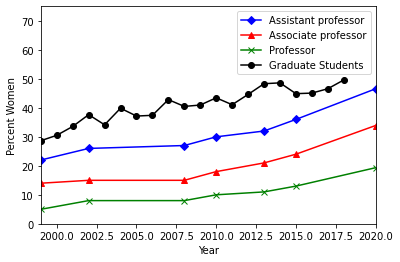

In [9]:
marker = ['D','^','x']
color = ['b','r','g']
for idx, f in enumerate(faculty_time_df.columns):
  plt.plot(faculty_time_df[f], color = color[idx], marker = marker[idx], label = f.capitalize())
plt.plot(grad_time_df['percent_female'], 'ko-', label = 'Graduate Students')
plt.legend();
plt.xlim([1999, 2020])
plt.ylim([0, 75])
plt.xlabel('Year');
plt.ylabel('Percent Women');

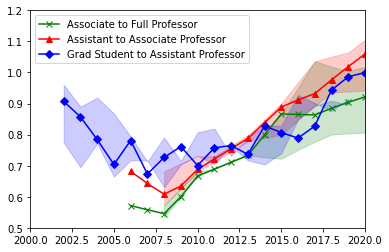

In [11]:
plt.plot(faculty_grad_df['professor interp frac 7'],'gx-', label='Associate to Full Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['professor interp frac 9'],faculty_grad_df['professor interp frac 5'], color = 'g', alpha = 0.2)
plt.plot(faculty_grad_df['associate professor interp frac 7'],'r^-', label='Assistant to Associate Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['associate professor interp frac 9'],faculty_grad_df['associate professor interp frac 5'], color = 'r', alpha = 0.2)
plt.plot(faculty_grad_df['assistant professor interp frac 3'],'bD-', label='Grad Student to Assistant Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['assistant professor interp frac 1'],faculty_grad_df['assistant professor interp frac 5'], color = 'b', alpha = 0.2)
plt.legend()
plt.xlim([2000, 2020])
plt.ylim([0.5, 1.2]);

# Figure 2: Faculty gender distribution by sub-discipline

In [12]:
subdisc_names = ['atmospheric chemistry','atmospheric dynamics',
         'geology','geophysics','geochemistry',
         'geobiology','chemical oceanography','biological oceanography',
         'physical oceanography','glaciology','hydrology','planetary science',
         'climate dynamics','sustainability','geomorphology','ecology','paleontology',
         'marine geology']



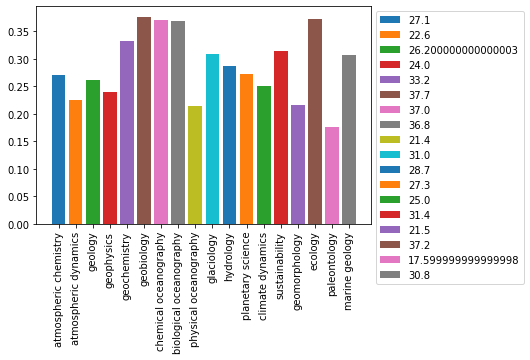

In [13]:
for sd in subdisc_names:
  percent_f = (disc_df[disc_df['Discipline'].str.contains(sd, na=False)].loc[disc_df['Gender'] == 'f']['Discipline'].count()/
               disc_df[disc_df['Discipline'].str.contains(sd, na=False)]['Discipline'].count())
  plt.bar(sd, percent_f, label = np.round(percent_f,3)*100)
  plt.xticks(rotation = 90)
  plt.legend( bbox_to_anchor=(1, 1))


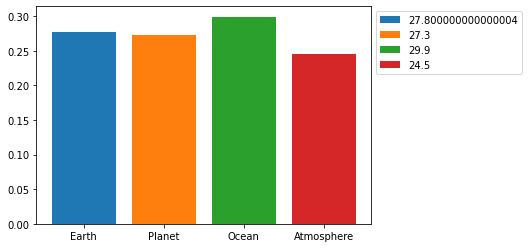

In [14]:
for d in ['Earth','Planet','Ocean','Atmosphere']:
  percent_f = (disc_df[disc_df['EPAO'] == d].loc[disc_df['Gender'] == 'f']['Discipline'].count()/
               disc_df[disc_df['EPAO'] == d]['Discipline'].count())
  plt.bar(d, percent_f, label = np.round(percent_f,3)*100)
  plt.legend( bbox_to_anchor=(1, 1))

# Figure 3: Hiring Model - projected gender distribution over time and estimated percentage of women hired

## Model to compute percentage of women hired each year

In [15]:
def percent_women_hired(yrs_2tenure, num_asst, yearly_hire, position):
  '''This function calculates the percent of women hired based on the years to tenure defined, the number of assistant professors defined, 
  a defined yearly hire (prior to data available), and the position we're looking at'''
  for yr in range(1999-yrs_2tenure,1999):
    #assume assistant prof % was same as in 1999 for previous years, with varying years for tenure
    faculty_grad_df[position +' interp'].loc[yr] = faculty_grad_df[position +' interp'][1999]
  faculty_grad_df[position +' num female ' + str(yrs_2tenure)] = faculty_grad_df[position +' interp']*num_asst/100
  faculty_grad_df[position +' num male '+ str(yrs_2tenure)] = (100-faculty_grad_df[position +' interp'])*num_asst/100
  faculty_grad_df[position +' delta female '+ str(yrs_2tenure)] = np.nan
  faculty_grad_df[position +' delta male '+ str(yrs_2tenure)] = np.nan
  for i in range(1999-yrs_2tenure,2021):
    faculty_grad_df[position +' delta female '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' num female '+ str(yrs_2tenure)].loc[i] - 
                                                                            faculty_grad_df[position +' num female '+ str(yrs_2tenure)].loc[i-1])
    faculty_grad_df[position +' delta male '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' num male '+ str(yrs_2tenure)].loc[i] - 
                                                                          faculty_grad_df[position +' num male '+ str(yrs_2tenure)].loc[i-1])

  faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)] = 15.4
  faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)] = 54.6
  for i in range(1999,2021):
    faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' delta female '+ str(yrs_2tenure)].loc[i]+
                                                                                 faculty_grad_df[position +' num female hired '+ str(yrs_2tenure)].loc[i-yrs_2tenure])
    faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' delta male '+ str(yrs_2tenure)].loc[i]+
                                                                               faculty_grad_df[position +' num male hired '+ str(yrs_2tenure)].loc[i-yrs_2tenure])
  faculty_grad_df[position + ' percent female hired '+ str(yrs_2tenure)] = (faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)]/
                                                                            (faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)] + 
                                                                             faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)]))

In [16]:
for i in range(6,9,1):
  percent_women_hired(i, 505, 70, 'assistant professor')

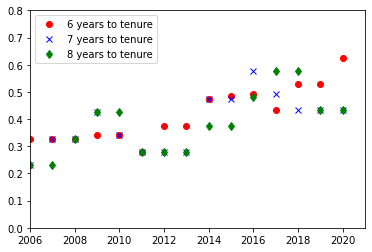

In [17]:
marker = ['o','x','d']
color = ['r','b','g']
for i in range(6,9,1):
  plt.plot(faculty_grad_df[f'assistant professor percent female hired {i}'],marker = marker[i-6], color = color[i-6], linestyle = 'none', label = f'{i} years to tenure')
plt.xlim([2006, 2021])
plt.ylim([0, 0.8])
plt.legend();

## Model to project time to gender parity

In [153]:
def hiring_model(start_year, end_year, assistant_pool, associate_pool, full_pool, 
                 num_female_assist, num_female_assoc, num_female_full, 
                 career_length, promotion1, promotion2, flux, hiring_ratio):
  '''This function calculates the time to gender parity based on a start and end year; total (m&f) assistant, associate and full professor pool;
  number of female assistant, associate and full professors; career length; time to promotion for tenure, time to promotion to full professor; 
  estimated flux in/out of the field; and a desired hiring ratio (the current hiring ratio is automatically calculated)'''
  
  future_df = pd.DataFrame(index = np.arange(start_year, end_year), columns = ['assistant_pool','associate_pool','full_pool',
                                                                               'assistant_f_frac','associate_f_frac','full_f_frac',
                                                                               'full_flux','associate_flux','assistant_flux'])
  num_years = end_year-start_year
  #assign the pool of data from inputs
  future_df['assistant_pool'].loc[start_year] = assistant_pool
  future_df['associate_pool'].loc[start_year] = associate_pool
  future_df['full_pool'].loc[start_year] = full_pool
  #calculate fraction that are women
  future_df['assistant_f_frac'].loc[start_year] = num_female_assist/assistant_pool
  future_df['associate_f_frac'].loc[start_year] = num_female_assoc/associate_pool
  future_df['full_f_frac'].loc[start_year] = num_female_full/full_pool
  #number of years between being a full professor and retirement
  retire = career_length - promotion1 - promotion2 
  # assume even distribution across faculty ranks
  future_df['full_flux'].loc[start_year] = full_pool/retire
  future_df['associate_flux'].loc[start_year] = associate_pool/promotion2
  future_df['assistant_flux'].loc[start_year] = assistant_pool/promotion1
  #future scenarios hiring
  for ratio in [hiring_ratio, (num_female_assist/assistant_pool)]:
    #full prof
    future_df[f'full {ratio} hiring ratio'] = np.nan
    for i in range(start_year,end_year-retire-promotion2-promotion1):
      future_df.loc[i, f'full {ratio} hiring ratio'] = ratio
    for i in range(end_year-retire-promotion2-promotion1, end_year-retire-promotion2):
      future_df.loc[i, f'full {ratio} hiring ratio'] = num_female_assist/assistant_pool
    for i in range(end_year-retire-promotion2, end_year-retire):
      future_df.loc[i, f'full {ratio} hiring ratio'] = num_female_assoc/associate_pool
    for i in range(end_year-retire, end_year):
      future_df.loc[i, f'full {ratio} hiring ratio'] = num_female_full/full_pool
    #associate prof
    future_df[f'associate {ratio} hiring ratio'] = np.nan
    for i in range(start_year,end_year-promotion2-promotion1):
      future_df.loc[i, f'associate {ratio} hiring ratio'] = ratio
    for i in range(end_year-promotion2-promotion1, end_year-promotion2):
      future_df.loc[i, f'associate {ratio} hiring ratio'] = num_female_assist/assistant_pool
    for i in range(end_year-promotion2, end_year):
      future_df.loc[i, f'associate {ratio} hiring ratio'] = num_female_assoc/associate_pool
    #assistant prof
    future_df[f'assistant {ratio} hiring ratio'] = np.nan
    for i in range(start_year,end_year-promotion1):
      future_df.loc[i, f'assistant {ratio} hiring ratio'] = ratio
    for i in range(end_year-promotion1, end_year):
      future_df.loc[i, f'assistant {ratio} hiring ratio'] = num_female_assist/assistant_pool
 
    #pool of faculty
    future_df[f'assistant_pool_female {ratio}'] = num_female_assist
    future_df[f'associate_pool_female {ratio}'] = num_female_assoc
    future_df[f'full_pool_female {ratio}'] = num_female_full

    #calculate future pools
    x = num_years-1
    for i in range(start_year+1,end_year):
      x = x-1
      future_df.loc[i, f'full_pool_female {ratio}'] = (future_df[f'full_pool_female {ratio}'].loc[i-1] - 
                                            flux*future_df[f'full {ratio} hiring ratio'].iloc[x] + 
                                            flux*future_df[f'associate {ratio} hiring ratio'].iloc[x])
      future_df.loc[i, f'associate_pool_female {ratio}'] = (future_df[f'associate_pool_female {ratio}'].loc[i-1] - 
                                            flux*future_df[f'associate {ratio} hiring ratio'].iloc[x] + 
                                            flux*future_df[f'assistant {ratio} hiring ratio'].iloc[x])
      future_df.loc[i, f'assistant_pool_female {ratio}'] = (future_df[f'assistant_pool_female {ratio}'].loc[i-1] - 
                                            flux*future_df[f'assistant {ratio} hiring ratio'].iloc[x] + 
                                            flux*ratio)
    #projections of fractions
    future_df[f'projected total {ratio}'] = ((future_df[f'full_pool_female {ratio}']+future_df[f'associate_pool_female {ratio}']+future_df[f'assistant_pool_female {ratio}'])/
                                             (assistant_pool+associate_pool+full_pool))
    future_df[f'projected full {ratio}'] = ((future_df[f'full_pool_female {ratio}'])/
                                             (full_pool))
    future_df[f'projected associate {ratio}'] = ((future_df[f'associate_pool_female {ratio}'])/
                                             (associate_pool))
    future_df[f'projected assistant {ratio}'] = ((future_df[f'assistant_pool_female {ratio}'])/
                                             (assistant_pool))
    #limit our growth to 50% women max
    for lev in ['assistant','associate','full', 'total']: 
      future_df.loc[future_df[f'projected {lev} {ratio}'] >=.5, f'projected {lev} {ratio}'] = 0.5 

  return(future_df)


In [154]:
projection_df = hiring_model(start_year = 2020, end_year = 2071, assistant_pool = 505, associate_pool = 466, full_pool = 1471, 
                 num_female_assist = 236, num_female_assoc = 158, num_female_full = 284, 
                 career_length = 35, promotion1 = 7, promotion2 = 7, flux = 70, hiring_ratio = .5)

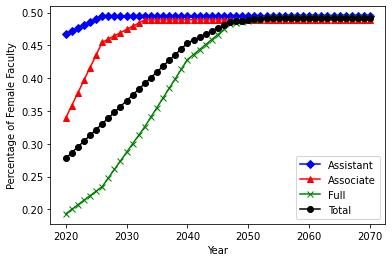

In [156]:
marker = ['D','^','x','o']
color = ['b','r','g','k']

for i, lev in enumerate(['assistant','associate','full', 'total']):
  plt.plot(projection_df[f'projected {lev} 0.5'],marker = marker[i], color = color[i], label = lev.capitalize())
  plt.legend()
plt.xlabel('Year');
plt.ylabel('Percentage of Female Faculty');
